# Stations and utilities

Here we simulate two players, one of which is not very interested in buying stations or utilities. This is done to test a few theories that circulate over the web, suggesting not to bother buying utilities. We test a few scenarios, where a player never buys stations or utilities, or when it doesn't buy if someone else already owns at least one.

In [20]:
import os

os.chdir('..')

from monosim.player import Player
from monosim.board import get_board, get_roads, get_properties, get_community_chest_cards, get_bank
import random
import pandas as pd
from scipy.stats import binom_test
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

## Do not buy stations

Here we modify the behaviour of one of the two players. In particular, one of the two players will never buy stations. To change the player's behaviour we modify the function buy(), responsible for buying roads. To see how to modify functions' behaviour see notebook: [dummy_vs_no_brown_player](https://github.com/giogix2/monopoly_simulator/blob/master/notebooks/dummy_vs_no_brown_players.ipynb).

In [21]:
# from https://stackoverflow.com/questions/24768400/how-would-one-decorate-an-inherited-method-in-the-child-class
def modify_buy(buy_property):
    def _wrapper(self, dict_property_info):
        if dict_property_info['type'] == 'station':
            pass
        else:
            buy_property(self, dict_property_info)
    return _wrapper

class Player_no_station(Player):
    buy_property = modify_buy(Player.buy_property)

In [22]:
def launch_simulation():
    list_results = []

    for seed in tqdm(range(0, 10000)):
        random.seed(seed)
        bank = get_bank()
        dict_board = get_board()
        dict_roads = get_roads()
        dict_properties = get_properties()
        dict_community_chest_cards = get_community_chest_cards()
        community_cards_deck = list(dict_community_chest_cards.keys())
        player1 = Player_no_station('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        player2 = Player('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

        player1.meet_other_players([player2])
        player2.meet_other_players([player1])

        list_players = [player1, player2]
        random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

        idx_count = 0
        while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
            for player in list_players:
                player.play()
            idx_count += 1

        if player1.has_lost():
            list_results.append((seed, 'player1_lost', list_players[0]._name))
        elif player2.has_lost():
            list_results.append((seed, 'player2_lost', list_players[0]._name))
        else:
            list_results.append((seed, 'nobody_lost', list_players[0]._name))
    return list_results

list_results = launch_simulation()

100%|██████████| 10000/10000 [00:29<00:00, 334.67it/s]


In [23]:
def print_results(list_results):
    df_res = pd.DataFrame(list_results, columns=['seed', 'lost_player', 'starting_player'])
    n_lost_p1 = df_res[df_res.lost_player == 'player1_lost'].shape[0]
    n_lost_p2 = df_res[df_res.lost_player == 'player2_lost'].shape[0]
    count_start_p1 = df_res[(df_res.starting_player == 'player1') & (df_res.lost_player != 'nobody_lost')].shape[0]
    count_start_p2 = df_res[(df_res.starting_player == 'player2') & (df_res.lost_player != 'nobody_lost')].shape[0]

    print('player 1 started {} times and lost {} times'.format(count_start_p1, n_lost_p1))
    print('player 2 started {} times and lost {} times'.format(count_start_p2, n_lost_p2))
    print('nobody lost {} times'.format(df_res[df_res.lost_player == 'nobody_lost'].shape[0]))
    return n_lost_p1, n_lost_p2

n_lost_p1, n_lost_p2 = print_results(list_results)

player 1 started 4426 times and lost 5933 times
player 2 started 4480 times and lost 2973 times
nobody lost 1094 times


In [24]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

6.470686453128216e-220

It can be noted how avoiding buying stations is not a winning strategy on average. Player 2 loses almost twice compared with player 1. In the next section, we implement a variant of player 2, which avoids buying stations only when some other player already bought one.

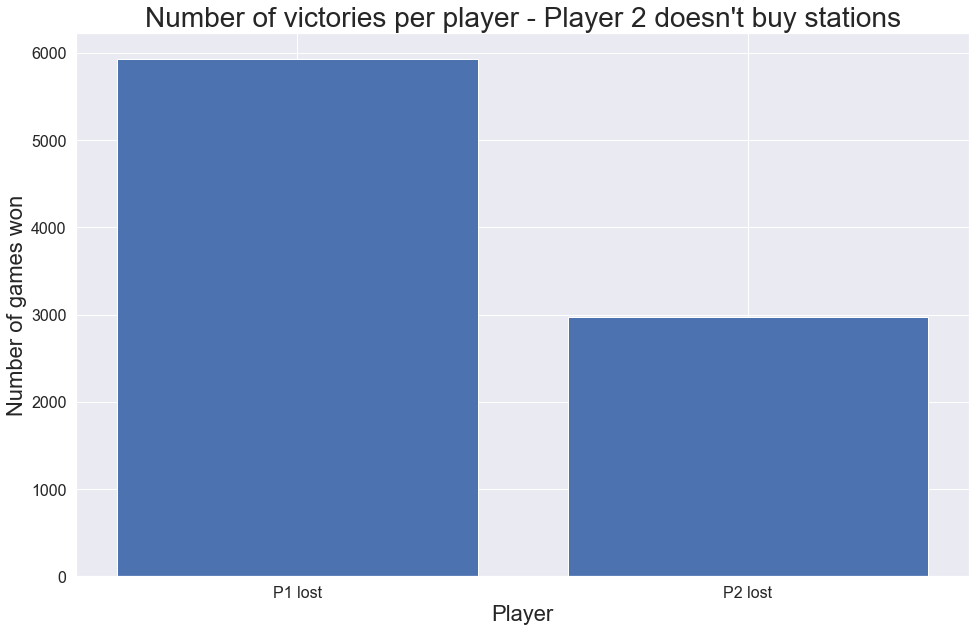

In [26]:
f, ax = plt.subplots(figsize=(16,10))
plt.bar(x = ['P1 lost', 'P2 lost'], height = [n_lost_p1, n_lost_p2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title("Number of victories per player - Player 2 doesn't buy stations", fontsize=28)
ax.set_xlabel('Player', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)

fig = ax.get_figure()
fig.savefig('monopoly_simulator/images/no_stations.png')

## Do not buy stations (when other players already own at least one)

Here we implement a version of Player that doesn't buy stations when at least another opponent has one. The idea behind this is to test whether stations start being inefficient purchases when it's not possible to get the additional income for having all four stations.

In [27]:
# from https://stackoverflow.com/questions/24768400/how-would-one-decorate-an-inherited-method-in-the-child-class
def modify_buy(buy_property):
    def _wrapper(self, dict_property_info):
        if dict_property_info['type'] == 'station':
            stations_owned_by_others = False
            for p in self._list_players:
                if len(p._list_owned_stations) > 0:
                    stations_owned_by_others = True
            if stations_owned_by_others:
                pass
            else:
                buy_property(self, dict_property_info)
        else:
            buy_property(self, dict_property_info)
    return _wrapper

class Player_no_station(Player):
    buy_property = modify_buy(Player.buy_property)

In [28]:
list_results = launch_simulation()
n_lost_p1, n_lost_p2 = print_results(list_results)

100%|██████████| 10000/10000 [00:31<00:00, 318.94it/s]


player 1 started 4375 times and lost 5062 times
player 2 started 4423 times and lost 3736 times
nobody lost 1202 times


In [29]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

1.7911604713052527e-45

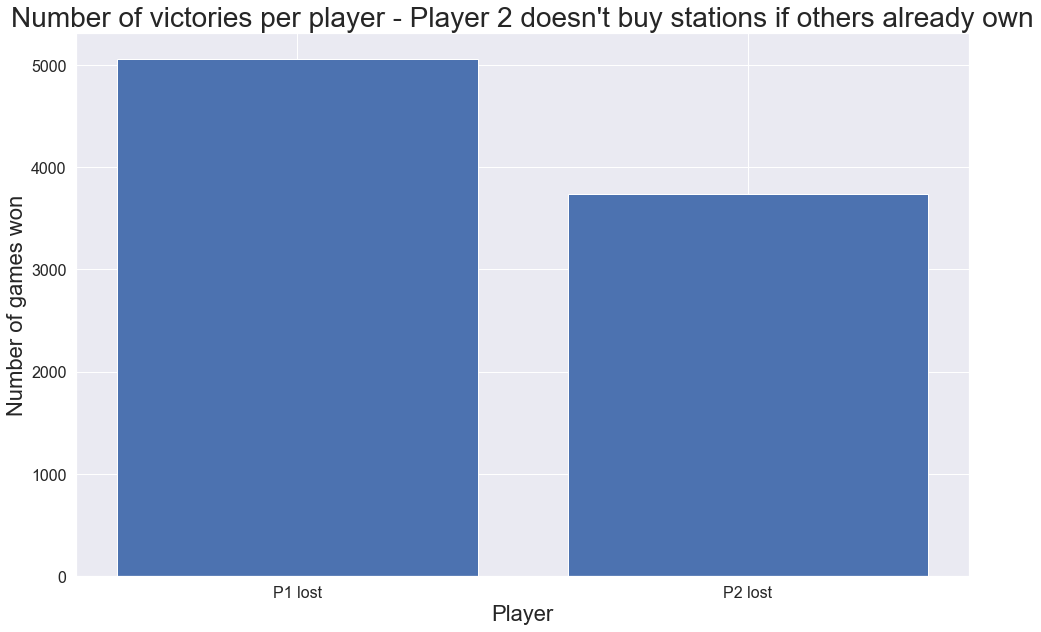

In [30]:
f, ax = plt.subplots(figsize=(16,10))
plt.bar(x = ['P1 lost', 'P2 lost'], height = [n_lost_p1, n_lost_p2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title("Number of victories per player - Player 2 doesn't buy stations if others already own", fontsize=28)
ax.set_xlabel('Player', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)

fig = ax.get_figure()
fig.savefig('monopoly_simulator/images/no_stations_if_other_own.png')

## Do not buy utilities

As done above, here we create a player that doesn't buy utilities.

In [31]:
# from https://stackoverflow.com/questions/24768400/how-would-one-decorate-an-inherited-method-in-the-child-class
def modify_buy(buy_property):
    def _wrapper(self, dict_property_info):
        if dict_property_info['type'] == 'utility':
            pass
        else:
            buy_property(self, dict_property_info)
    return _wrapper

class Player_no_station(Player):
    buy_property = modify_buy(Player.buy_property)

In [32]:
list_results = launch_simulation()
n_lost_p1, n_lost_p2 = print_results(list_results)

100%|██████████| 10000/10000 [00:32<00:00, 311.03it/s]

player 1 started 4332 times and lost 4438 times
player 2 started 4375 times and lost 4269 times
nobody lost 1293 times


In [33]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

0.07178747823768594

Unlike before, the difference in the number of victories between the two players is much smaller compared with the no-stations strategy.

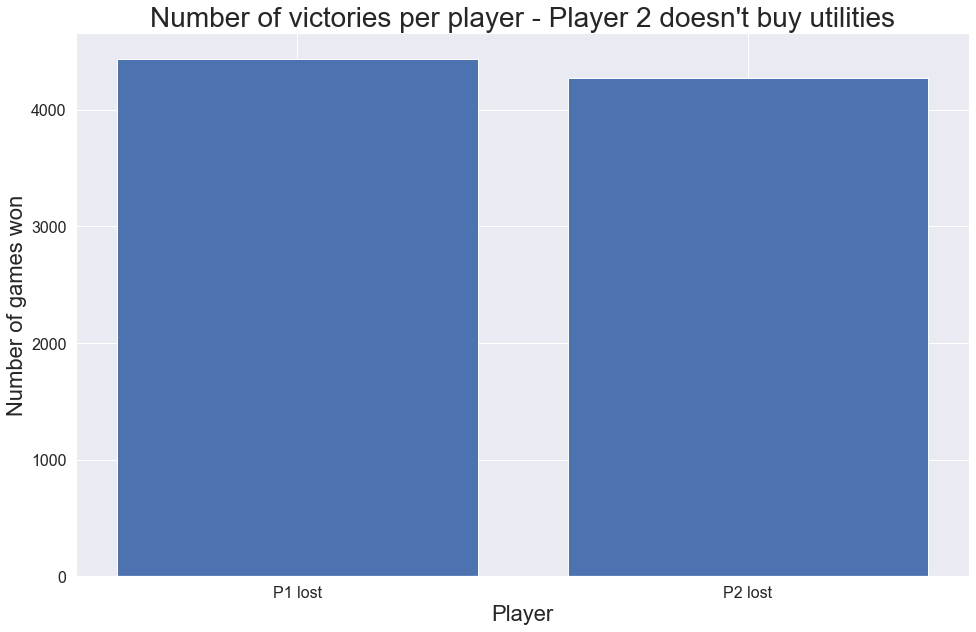

In [34]:
f, ax = plt.subplots(figsize=(16,10))
plt.bar(x = ['P1 lost', 'P2 lost'], height = [n_lost_p1, n_lost_p2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title("Number of victories per player - Player 2 doesn't buy utilities", fontsize=28)
ax.set_xlabel('Player', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)

fig = ax.get_figure()
fig.savefig('monopoly_simulator/images/no_utilities.png')

## Do not buy utilities (when other players already own at least one)

Do not buy utilities if at least one player has already already one.

In [35]:
# from https://stackoverflow.com/questions/24768400/how-would-one-decorate-an-inherited-method-in-the-child-class
def modify_buy(buy_property):
    def _wrapper(self, dict_property_info):
        if dict_property_info['type'] == 'utility':
            utilities_owned_by_others = False
            for p in self._list_players:
                if len(p._list_owned_utilities) > 0:
                    utilities_owned_by_others = True
            if utilities_owned_by_others:
                pass
            else:
                buy_property(self, dict_property_info)
        else:
            buy_property(self, dict_property_info)
    return _wrapper

class Player_no_station(Player):
    buy_property = modify_buy(Player.buy_property)

In [36]:
list_results = launch_simulation()
n_lost_p1, n_lost_p2 = print_results(list_results)

100%|██████████| 10000/10000 [00:32<00:00, 307.91it/s]

player 1 started 4324 times and lost 4299 times
player 2 started 4363 times and lost 4388 times
nobody lost 1313 times


In [37]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

0.34508599152217084

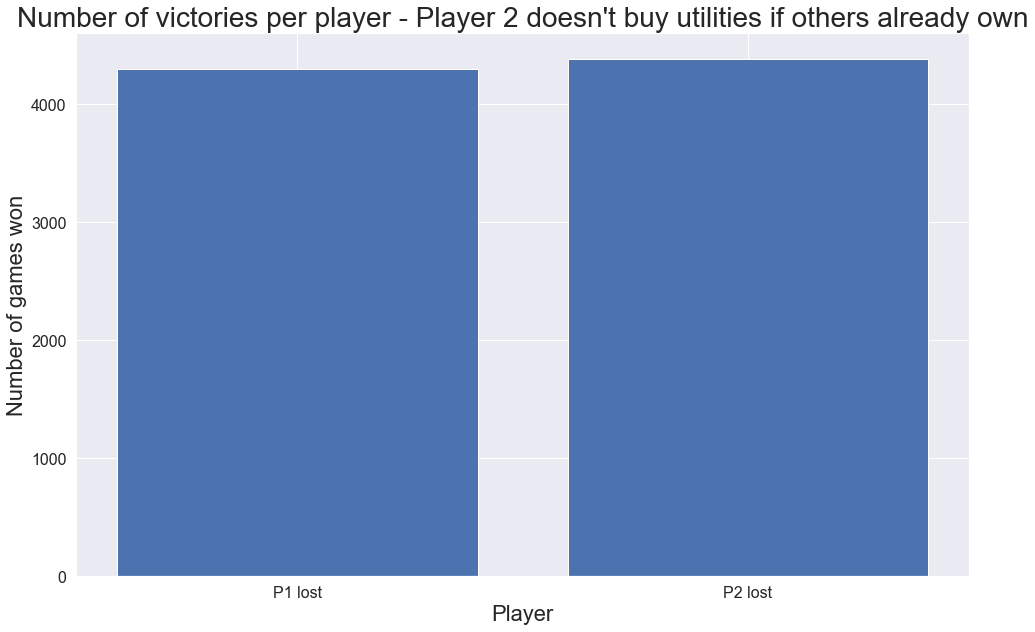

In [38]:
f, ax = plt.subplots(figsize=(16,10))
plt.bar(x = ['P1 lost', 'P2 lost'], height = [n_lost_p1, n_lost_p2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title("Number of victories per player - Player 2 doesn't buy utilities if others already own", fontsize=28)
ax.set_xlabel('Player', fontsize=22)
ax.set_ylabel('Number of games won', fontsize=22)

fig = ax.get_figure()
fig.savefig('monopoly_simulator/images/no_utilities_if_other_own.png')